Data: 31, Nodes: 4249, Edges: 6046
{4060029000: [126.512734734648, 33.2546781470705], 4060187801: [126.393318242941, 33.3024873661656], 4060014200: [126.427824763833, 33.2404562739723], 4050113000: [126.667921008318, 33.5294259271958], 4050113700: [126.702717929053, 33.5433495414616], 4050113900: [126.693206207319, 33.5500237666183], 4060000800: [126.478039080718, 33.2511516704185], 4060003403: [126.595401810657, 33.259624267661], 4060004001: [126.612293095372, 33.2611697419915], 4060004201: [126.428245623643, 33.258049186505], 4060073300: [126.467102315343, 33.263421015703], 4060073400: [126.474326735403, 33.2561718396282], 4060073900: [126.514023434851, 33.2366074758841], 4060074300: [126.475651731667, 33.2362573635155], 4060076200: [126.561106833762, 33.2468565391276], 4050000503: [126.489959245415, 33.41828117736], 4050000600: [126.616698292577, 33.4191031477377], 4050129700: [126.258499828867, 33.3048245714679], 4050130300: [126.259139099184, 33.4094155336075], 4050164300: [126.40

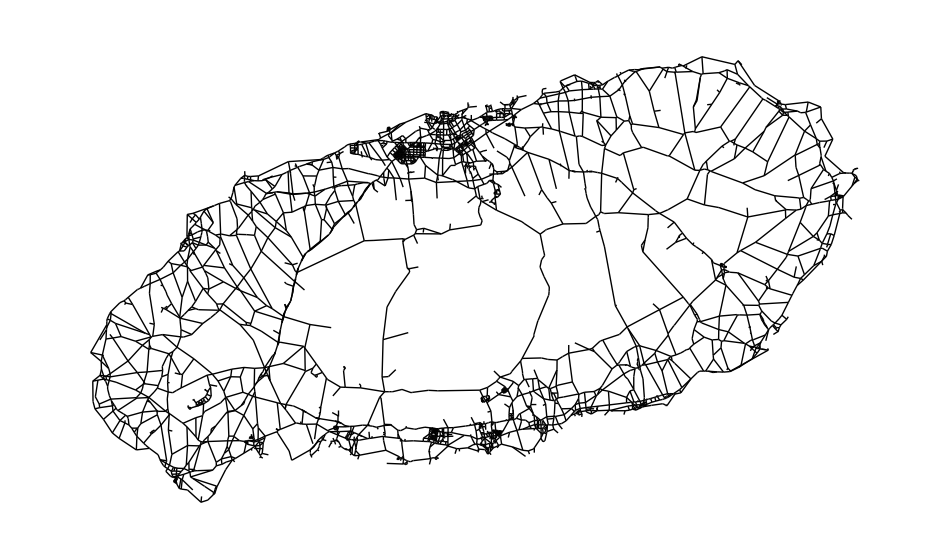

In [25]:
import pandas as pd
import numpy as np
import networkx as nx
from haversine import haversine
import cv2
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline

nodes = pd.read_csv('data/Jeju_nodes.csv', encoding='utf-8')
links = pd.read_csv('data/Jeju_links.csv', encoding='cp949')
car = pd.read_csv('data/Jeju_car.csv', encoding='cp949')

nodes = nodes[['Id','NODE_NAME','latitude','longitude', 'average population']]
links = links[['Source','Target', '시간']]
source_in = links['Source'].apply(lambda x : x in list(nodes['Id'])) # check Sources are in jeju
target_in = links['Target'].apply(lambda x : x in list(nodes['Id'])) # check Targets are in jeju
# source_in and target_in are boolean type pandas.Series which contains True or False
jeju_links = links[source_in & target_in] # contain if both target and source are contained in jeju

G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
# make a dictionary for node position

def connectRes(graph, df): # df는 idx, latitude, longitude가 있어야함
    nodes_latitude = nx.get_node_attributes(graph, 'latitude')
    nodes_longitude = nx.get_node_attributes(graph, 'longitude')
    for idx, row in df.iterrows():
        distances ={}
        for keyLong, valLat in nodes_latitude.items():
            nodesPos = (valLat, nodes_longitude[keyLong])
            curPos = (row['latitude'], row['longitude'])
            distances[keyLong] = haversine(nodesPos, curPos, unit='km')
        nearest_node = min(distances, key=distances.get)
        graph.add_node(idx, Label=idx, latitude=row['latitude'], longitude=row['longitude']) ##노드이름은 4050000000이하로 설정
        w = distances[nearest_node]*1000/666 #단위 변환 km->m(*1000), 거리(m)->시간(분) (40km/h = 666m/s)
        graph.add_edge(nearest_node, idx, weight=w) 
    return graph
G = connectRes(G, car)
print(f"Data: {len(car)}, Nodes: {len(G.nodes)}, Edges: {len(G.edges)}")

pos = {}
for node in G.nodes(data=True):
    pos[node[0]] = [node[1]['longitude'], node[1]['latitude']]
print(pos)

# "G" is a network, "nodelist" is a list of node to select
def draw(G, nodelist=None, select_color = 'red', title = ''):
    plt.figure(figsize= (12, 7))
    plt.cla()
    plt.axis('off')
    if title:
        plt.title(title, loc='left')
    nx.draw_networkx(G, pos=pos, node_size = 0, with_labels=False)
    if nodelist != None:
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=select_color, node_size=1)
        edge_colors = [select_color if (u in nodelist and v in nodelist) else 'black' for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    plt.show()
def saveImg(G, nodelist=None, select_color = 'red', name = 'saveImg.png', title=''):
    plt.figure(figsize= (12, 7))
    plt.axis('off')
    if title:
        plt.title(title, loc='left')
    nx.draw_networkx(G, pos=pos, node_size = 0, with_labels=False)
    if nodelist != None:
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=select_color, node_size=1)
        edge_colors = [select_color if (u in nodelist and v in nodelist) else 'black' for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    plt.savefig(name, bbox_inches='tight', pad_inches=0.2)

print(nodes.columns)
print(nodes.head())
draw(G)

119 index list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
total population in area: 377900.0
service area 5min time: 0.41954994201660156


C:\Flutter\bin\ipykernel_5476\733621746.py:65: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors)


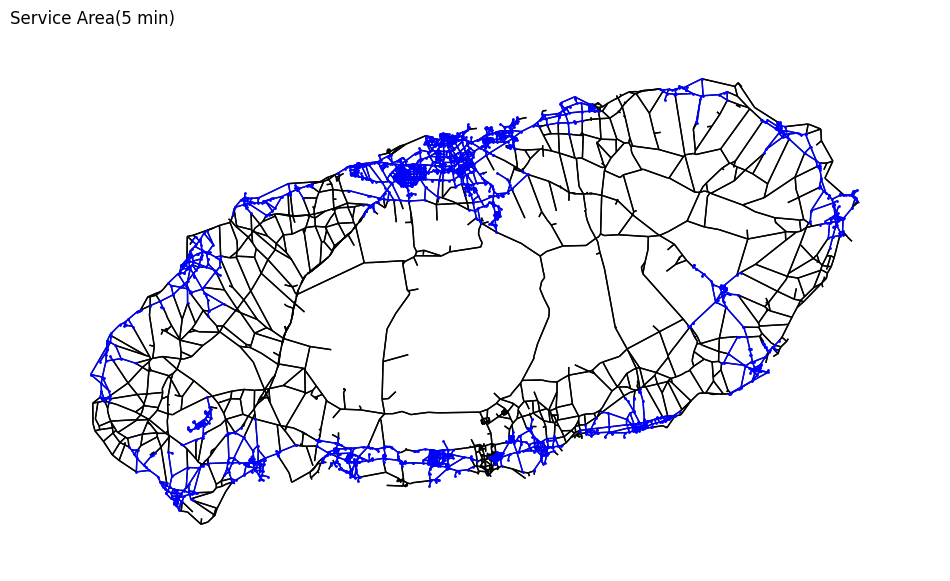

In [22]:
def serviceArea(graph, nodelist = [], w =5):
    ret = {}
    for node in nodelist:
        shortest_paths = nx.single_source_dijkstra_path_length(graph, node, cutoff=w, weight='weight')
        tmp=ret
        for key in set(shortest_paths.keys()).intersection(ret.keys()):
            tmp[key] = min(shortest_paths[key], ret[key])
        tmp.update({key: shortest_paths[key] for key in set(shortest_paths.keys()) - set(ret.keys())})
        tmp.update({key: ret[key] for key in set(ret.keys()) - set(shortest_paths.keys())})
        ret = tmp
    return ret

t1 = time.time()
area = {}
carlist = car.index.tolist()
print(f"119 index list: {carlist}")
area = serviceArea(G, carlist, w=5)
sum = 0
for key, val in area.items():
    if key >1000:
        sum += nodes.loc[nodes['Id'] == key, 'average population'].values[0]
print(f"total population in area: {sum}")
t2 = time.time()
print(f'service area 5min time: {t2-t1}')
draw(G, area, 'blue', title="Service Area(5 min)")


In [26]:
carlist = car.index.tolist()
for carNum in carlist:
    area = serviceArea(G, [carNum], w=5)
    sum = 0
    for key, val in area.items():
        if key >1000:
            sum += nodes.loc[nodes['Id'] == key, 'average population'].values[0]
    print(f"car{carNum} people: {sum}")


car0 people: 44550.0
car1 people: 19853.0
car2 people: 19853.0
car3 people: 6968.0
car4 people: 20691.0
car5 people: 51777.0
car6 people: 11962.0
car7 people: 11327.0
car8 people: 9790.0
car9 people: 10971.0
car10 people: 63604.0
car11 people: 5109.0
car12 people: 6031.0
car13 people: 5340.0
car14 people: 5340.0
car15 people: 13534.0
car16 people: 17744.0
car17 people: 17744.0
car18 people: 11827.0
car19 people: 42828.0
car20 people: 29849.0
car21 people: 23340.0
car22 people: 11618.0
car23 people: 23340.0
car24 people: 22116.0
car25 people: 18848.0
car26 people: 4919.0
car27 people: 22176.0
car28 people: 20993.0
car29 people: 9213.0
car30 people: 22116.0
